In [1]:
import iminuit as iminuit
import optuna
import pandas as pd

from model import LightningFullyConnected, BigLightningModel
from verstack import LGBMTuner
from lightgbm import LGBMClassifier
import lightning as L
import numpy as np
import pandas as pd
from dataset import ParticleDataset
from torch import optim
from torch import nn
from torch.nn import functional as F
import pickle
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, log_loss

2023-05-17 18:42:22.500790: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 18:42:23.205226: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-17 18:42:23.205296: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-17 18:42:23.205303: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
hidden_channels = 40
decode_channels = 6
hidden_layers = 5
p_dropout = 0.1
lr = 0.0003
activation=nn.LeakyReLU
final_activation=nn.Sigmoid
batch_size=2500
optimizer=optim.AdamW
scheduler=optim.lr_scheduler.CosineAnnealingLR
loss_fn=F.binary_cross_entropy
in_channels=15
out_channels=1
use_wandb=True

model1: LightningFullyConnected = LightningFullyConnected.load_from_checkpoint("../data/initial/model1.ckpt")
model_big: LightningFullyConnected = BigLightningModel.load_from_checkpoint("../data/initial/modelbig1.ckpt")

model1.to("cpu")
model_big.to("cpu")

model1.eval()
model_big.eval()

with open("../data/initial/lgbm_tuner.pickle", "rb") as f:
    tuner: LGBMTuner = pickle.load(f)

data1_train, data1_val = ParticleDataset().split_data(0.8, seed=42)
data2_train, data2_val = ParticleDataset(target="ALL").split_data(0.8, seed=42)

data1_val[:][0].to("cpu")
data2_val[:][0].to("cpu")
data1_train[:][0].to("cpu")
data2_train[:][0].to("cpu")
data1_val[:][1].to("cpu")
data2_val[:][1].to("cpu")
data1_train[:][1].to("cpu")
data2_train[:][1].to("cpu")


print(data1_train[:][0].shape, data1_train[:][1].shape)
print(data2_train[:][0].shape, data2_train[:][1].shape)

torch.Size([130000, 15]) torch.Size([130000])
torch.Size([130000, 15]) torch.Size([130000, 160])


In [3]:
lgbm_hyper = {'task': 'train', 'learning_rate': 0.04, 'num_leaves': 166, 'feature_fraction': 0.8607121643836452, 'bagging_fraction': 0.9318657440733003, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'lambda_l1': 1, 'lambda_l2': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'max_bin': 255, 'min_data_in_bin': 3, 'random_state': 42, 'device_type': 'cpu', 'num_classes': 1, 'objective': 'binary', 'metric': 'binary_logloss', 'num_threads': 6, 'min_sum_hessian_in_leaf': 0.289813314023732, 'num_iterations': 313}

data_train_big = model_big(data1_train[:][0])
print(data_train_big.shape)
data_train_big = data_train_big.detach().numpy()

data_val_big = model_big(data1_val[:][0])
data_val_big = data_val_big.detach().numpy()
print(data_train_big.shape)

lgbm = LGBMClassifier(**lgbm_hyper)
lgbm_big = LGBMClassifier(**lgbm_hyper)
lgbm.fit(data1_train[:][0].numpy(), data1_train[:][1].numpy())
lgbm_big.fit(data_train_big, data1_train[:][1])

nn_proba = model1(data1_val[:][0]).detach().numpy()

nn_big_values = model_big(data1_val[:][0])
nn_big_values = nn_big_values.detach().numpy()

lgbm_proba = lgbm.predict_proba(data1_val[:][0].numpy())[:, 1]
lgbm_big_proba = lgbm_big.predict_proba(nn_big_values)[:, 1]

print(f"Normal: {np.mean(lgbm_proba)}")
print(f"Big: {np.mean(lgbm_big_proba)}")

torch.Size([130000, 160])
(130000, 160)
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_fraction is set=0.9318657440733003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9318657440733003
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.289813314023732, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.289813314023732
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8607121643836452, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8607121643836452
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
Normal: 0.7507278002943921
Big: 0.7541056182013764



 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 100 trials
     .. Evaluation metric: accuracy 
     .. Study direction: minimize log_loss

     . Trial number: 0 finished
     .. Optimization score (lower-better): log_loss: 0.16352292812283067
     .. Evaluation score (greater-better): accuracy: 0.9360923076923077
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): log_loss: 0.1614915090124941
     .. Evaluation score (greater-better): accuracy: 0.9365230769230769
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): log_loss: 0.16192777534382916
     .. Evaluation score (greater-better): accuracy: 0.9371384615384616
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): log_loss: 0

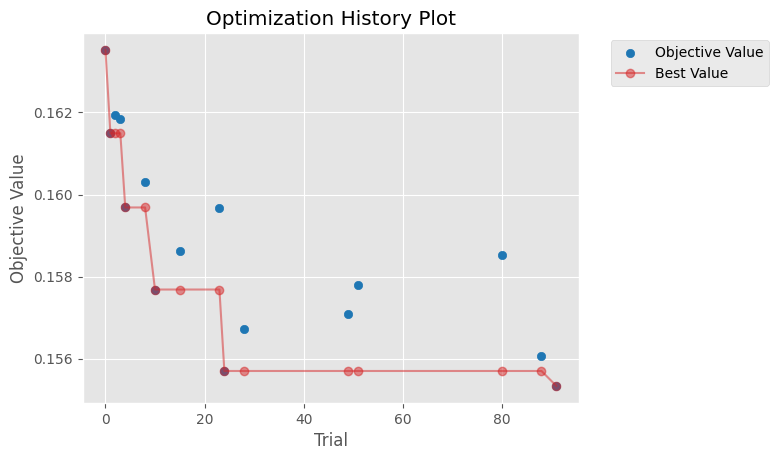

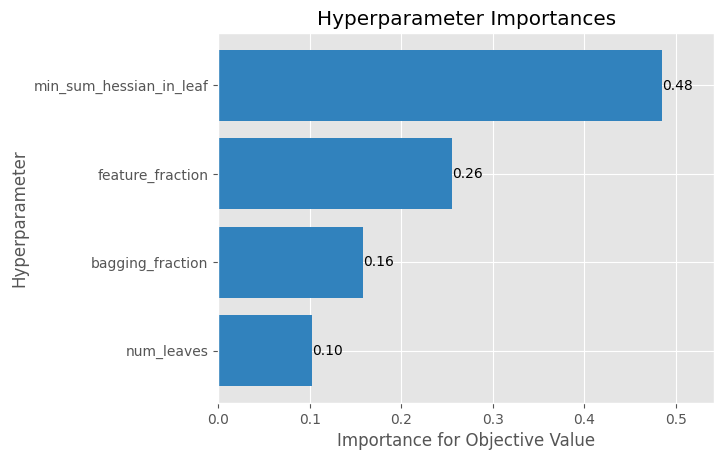

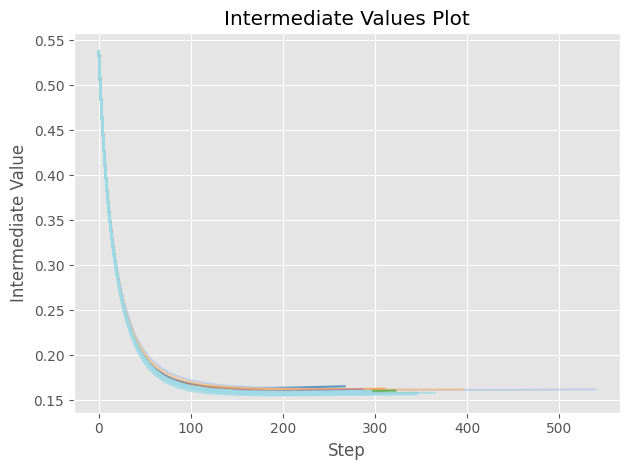

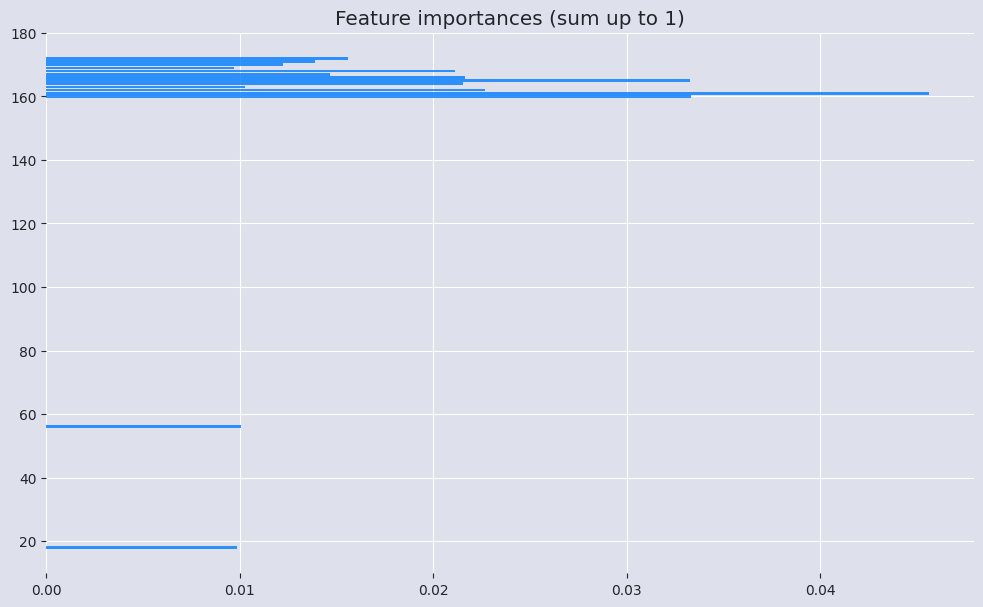


     . Optuna hyperparameters optimization finished
     .. Best trial number:91    |     log_loss:           0.1553385940716403
 ---------------------------------------------------------------------------
     . num_iterations optimization finished
     .. best iteration:  218   |     accuracy:           0.9372307692307692

Time elapsed for fit execution: 14 min 41.748 sec


In [4]:
biggest_tuner = LGBMTuner(metric="accuracy")
biggest_features = np.concatenate([data_train_big,
                                   data1_train[:][0].to("cpu"),
                                   ], axis=1)
biggest_val_features = np.concatenate([data_val_big,
                                       data1_val[:][0].to("cpu"),
                                       ], axis=1)
biggest_tuner.fit(pd.DataFrame(biggest_features), pd.Series(data1_train[:][1].numpy()))
biggest_proba = biggest_tuner.predict_proba(pd.DataFrame(biggest_val_features))

val_target = data1_val[:][1].detach().numpy()

In [5]:
print(f"lgbm acc: {accuracy_score(np.round(lgbm_proba), val_target)}")
print(f"nn acc: {accuracy_score(np.round(nn_proba), val_target)}")
print(f"lgbm big acc: {accuracy_score(np.round(lgbm_big_proba), val_target)}")
print(f"lgbm biggest acc: {accuracy_score(np.round(biggest_proba), val_target)}")

lgbm acc: 0.9384307692307692
nn acc: 0.9293230769230769
lgbm big acc: 0.9274153846153846
lgbm biggest acc: 0.9375384615384615


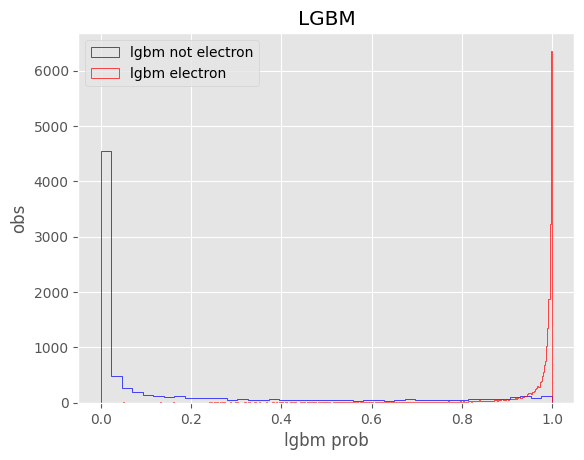

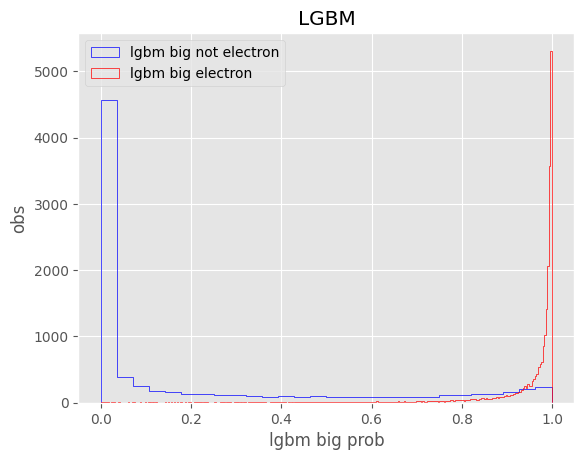

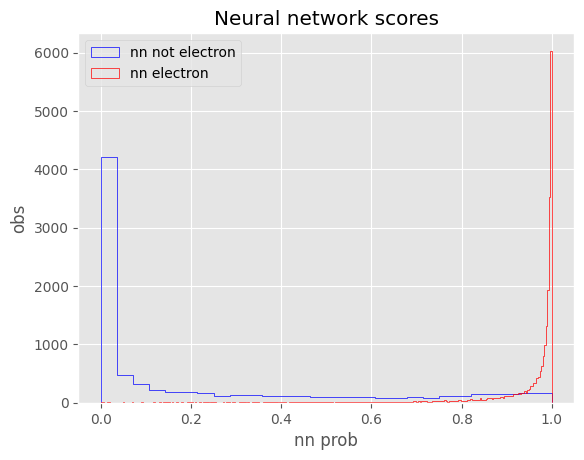

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 32500) + inhomogeneous part.

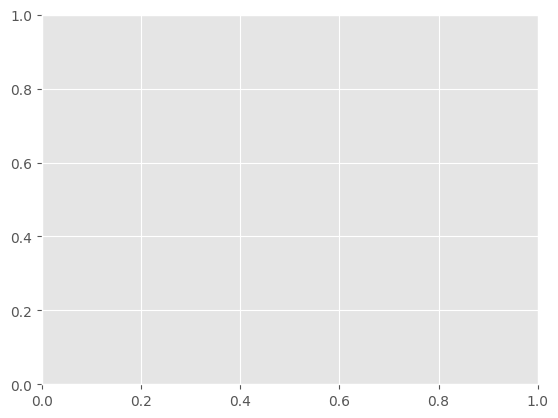

In [6]:

plt.hist(lgbm_proba[val_target == 0], bins="auto", label="lgbm not electron", color="b", histtype="step")
plt.hist(lgbm_proba[val_target == 1], bins="auto", label="lgbm electron", color="r", histtype="step")
plt.xlabel("lgbm prob")
plt.ylabel("obs")
plt.title("LGBM")
plt.legend()
plt.show()

plt.hist(lgbm_big_proba[val_target == 0], bins="auto", label="lgbm big not electron", color="b", histtype="step")
plt.hist(lgbm_big_proba[val_target == 1], bins="auto", label="lgbm big electron", color="r", histtype="step")
plt.xlabel("lgbm big prob")
plt.ylabel("obs")
plt.title("LGBM")
plt.legend()
plt.show()

plt.hist(nn_proba[val_target == 0], bins="auto", label="nn not electron", color="b", histtype="step")
plt.hist(nn_proba[val_target == 1], bins="auto", label="nn electron", color="r", histtype="step")
plt.xlabel("nn prob")
plt.ylabel("obs")
plt.title("Neural network scores")
plt.legend()
plt.show()

plt.hist2d(nn_proba, lgbm_proba, label="all", bins=(10, 10), range=((0.98, 1.0), (0.98, 1.0)))
plt.colorbar()
plt.xlabel("nn probabilities")
plt.ylabel("lgbm probabilities")
plt.title("nn vs. lgbm")
plt.legend()
plt.show()

plt.hist2d(nn_proba, lgbm_proba, label="all", bins=(10, 10), range=((0.0, 0.02), (0.0, 0.02)))
plt.colorbar()
plt.xlabel("nn probabilities")
plt.ylabel("lgbm probabilities")
plt.title("nn vs. lgbm")
plt.legend()
plt.show()


In [ ]:
proba1 = lgbm.predict_proba(data1_train[:][0].detach().numpy())[:, 1]
proba2 = model1(data1_train[:][0]).detach().numpy()[:, 0]
proba3 = np.array(biggest_tuner.predict_proba(pd.DataFrame(biggest_features)))

print(proba1)
print(proba2)
print(proba3)
print(val_target)
all_scores = []
all_frac = []
rng = np.random.default_rng(42)
for _ in range(100):
    fracs = rng.uniform(low=0, high=1, size=3)
    fracs /= np.sum(fracs)
    all_frac.append(fracs)
    score = np.sum(val_target == np.round(fracs[0] * proba1 + fracs[1] * proba2 + fracs[2] * proba3))
    all_scores.append(score)
    print(score, fracs)
